In [8]:
from math import log
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import operator
import pickle 
import decimal

## Tree-based Methods

In [137]:
def loadDataSet_2(fileName):
    dataList = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))      # map data to float()
        dataList.append(fltLine)
    return dataList

def showTree(dataList, yArr_pred=None, mode="regTree"):
    n = len(dataList)                                                    
    xcord = []; ycord = []      

    if (np.shape(dataList)[1] == 2):            # check the number of columns
        for i in range(n):   
            xcord.append(dataList[i][0]); ycord.append(dataList[i][1])    
    elif(np.shape(dataList)[1] == 3):
        for i in range(n):   
            xcord.append(dataList[i][1]); ycord.append(dataList[i][2])    

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)                                            
    ax.scatter(xcord, ycord, s = 20, c = 'blue',alpha = .5)      
    if(np.all(yArr_pred != None)):
        xMat_test = np.mat(xcord).T          
        srtInd = xMat_test.argsort(0)    
        xSort  = xMat_test[srtInd][:,0,:]    # copy the xMat_test in ascending order for pyplot
        ax.plot(xSort[:], yArr_pred[srtInd], c = 'red')  
    if(mode == "regTree"):
        plt.title('Regression  Tree')         
    elif(mode == "modTree"):
        plt.title('Model  Tree')  
    plt.xlabel('X')
    plt.show()


##########################   functions for building Regression Tree    ##########################

def regLeaf(dataMat):                      # calculate the MEAN value as the model for a Leaf node
    return np.mean(dataMat[:,-1])          # dataMat[:,-1]: the last column of dataMat is Y

def regErr(dataMat):                       # calculate the TOTAL Squared Error of the target variables in a given dataset
    return np.var(dataMat[:,-1]) * np.shape(dataMat)[0]            # var(x): mean((x_i - x.mean())**2)
    # the smaller the variance is, the better the split. Goal: try to use LEAST split to seperate the whole data set

##########################   functions for building Model Tree    ##############################

def linearSolve(dataMat):  # format the dataset into the target variable Y and the independent variable X
    m,n = np.shape(dataMat)
    X = np.mat(np.ones((m,n))); Y = np.mat(np.ones((m,1)))      # generate ones-matrix
    X[:,1:n] = dataMat[:,0:n-1];       # copy feature matrix to X, the 0th-column of matrix X is constant 1 as offset
    Y = dataMat[:,-1]                  # copy target matrix to Y
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:                   # check the inversability
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of Stop Condition')
    ws = xTx.I * (X.T * Y)                          # calculate the optimal weight matrix ws with least-squares method
    return ws,X,Y


def modelLeaf(dataMat):                             # generate a model for a leaf node
    ws,X,Y = linearSolve(dataMat)
    return ws

def modelErr(dataMat):                              # calculate the total squared error 
    ws,X,Y = linearSolve(dataMat)                   # of model against target
    yHat = X * ws
    return sum(np.power(Y - yHat, 2))        


##########################   functions for split    ##############################

def binSplitDataSet(dataMat, feature, value):                          # binary split
    mat0 = dataMat[np.nonzero(dataMat[:,feature] <= value)[0],:]       # np.nonzero(dataMat[:,feature] <= value)[0]: return index of target rows
    mat1 = dataMat[np.nonzero(dataMat[:,feature] > value)[0],:]        # np.nonzero(dataMat[:,feature] > value)[0]: return index of target rows
    return mat0, mat1

def chooseBestSplit(dataMat, leafType = regLeaf, errType = regErr, stopCond = (1,4)):
    minErrReduction = stopCond[0];         # stop condition: minimal Error reduction should be made through a new split
    minInstance = stopCond[1]              # stop condition: minimal amount of instances should be included in a leaf node
    if len(set(dataMat[:,-1].T.tolist()[0])) == 1:     # If all y-values are equal, NO SPLIT: Leaf node
        return None, leafType(dataMat)                 # calculate value for leaf node  
    
    m, n = np.shape(dataMat)      # get the size of dataset
    preError = errType(dataMat)   # setting the last feature as the best split and estimate its error for further compare
    bestError = float('inf');     # initialize bestError as an infinite value
    bestIndex = 0;                # initialize best splitting feature(Index) 
    bestValue = 0                 # initialize best splitting value
  
    for featIndex in range(n - 1):   # iterate all feature columns to find the splitting feature and splitting value
        for splitVal in set(dataMat[:,featIndex].T.tolist()[0]):    # iterate all x-values of ONE certain feature
            mat0, mat1 = binSplitDataSet(dataMat, featIndex, splitVal) 
            if (np.shape(mat0)[0] < minInstance) or (np.shape(mat1)[0] < minInstance): continue  # stop conditions met, NO SPLIT: Leaf node
            newError = errType(mat0) + errType(mat1)      # calculate the new error from two split sets
            if newError < bestError:                      # update if new error is smaller than best error
                bestIndex = featIndex
                bestValue = splitVal
                bestError = newError
                
    if (preError - bestError) < minErrReduction:                 # If stop conditions met, NO SPLIT: leaf node
        return None, leafType(dataMat)                           # calculate value for leaf node
    
    mat0, mat1 = binSplitDataSet(dataMat, bestIndex, bestValue)   # otherweise make the best split
    if (np.shape(mat0)[0] < minInstance) or (np.shape(mat1)[0] < minInstance):  # If stop conditions met, NO SPLIT: leaf node
        return None, leafType(dataMat)                            # calculate value for leaf node  
    return bestIndex, bestValue


##########################   functions for Creating and Pruning tree    ##############################

def createTree(dataMat_train, leafType = regLeaf, errType = regErr, stopCond = (1, 4)):
    feat, val = chooseBestSplit(dataMat_train, leafType, errType, stopCond)
    if feat == None: return val        # If stop condition met, return leaf value for the leaf node 
    retTree = {}                       # define retTree as dictionary
    retTree['spFeatIndex'] = feat
    retTree['spValue'] = val
    left_Set, right_Set = binSplitDataSet(dataMat_train, feat, val)
    retTree['left'] = createTree(left_Set, leafType, errType, stopCond)
    retTree['right'] = createTree(right_Set, leafType, errType, stopCond)
    return retTree  

def isTree(obj):      # check whether it is a tree or a leaf node
    return (type(obj).__name__ == 'dict') 
 

def getMean(tree):    # descend a tree untill it hits only leaf nodes, then take the MEAN value of both
    if isTree(tree['right']): 
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']): 
        tree['left'] = getMean(tree['left'])
    return (tree['left'] + tree['right']) / 2.0    


def prune(tree, testData):            # Post-pruning
    if np.shape(testData)[0] == 0:    # If no test data return MEAN value of left and right nodes 
        return getMean(tree)  
    
    if (isTree(tree['right']) or isTree(tree['left'])):  # split test data according to the trained tree
        lSet, rSet = binSplitDataSet(testData, tree['spFeatIndex'], tree['spValue'])
    if isTree(tree['left']): 
        tree['left'] = prune(tree['left'], lSet)      # prune the left subtree
    if isTree(tree['right']): 
        tree['right'] = prune(tree['right'], rSet)    # prune the right subtree
    if not isTree(tree['left']) and not isTree(tree['right']):     # if the leaf node of trained tree is reached
        
        #  test the total squared error with the value of leaf node of trained tree
        lSet, rSet = binSplitDataSet(testData, tree['spFeatIndex'], tree['spValue']) 
        errorNoMerge = np.sum(np.power(lSet[:,-1] - tree['left'], 2)) + np.sum(np.power(rSet[:,-1] - tree['right'], 2))

        #  test the total squared error with the MEAN value of leaf node of trained tree
        treeMean = (tree['left'] + tree['right']) / 2.0
        errorMerge = np.sum(np.power(testData[:,-1] - treeMean, 2))
        
        if errorMerge < errorNoMerge: 
  #          print("merging, tree['spFeatIndex']: {}, tree['spValue']:{}, tree['left']:{}, tree['right']:{}".format(tree['spFeatIndex'],tree['spValue'],tree['left'],tree['right']))
  #          print("treeMean:", treeMean)
  #          print("\n")
            return treeMean             # MERGE the left and right leaf node into one leaf node with MEAN value
        else: 
            return tree
    else: 
        return tree
    
    
    
##########################   functions for Prediction with Tree Model    ##############################

def regTreeEval(model, inDat):     # evaluate a Regression Tree leaf node
    return float(model)            # return the value at the leaf node


def modelTreeEval(model, inDat):   # evaluate a Model Tree leaf node
    n = np.shape(inDat)[1]
    X = np.mat(np.ones((1, n+1)))  # n+1 features, including the offset
    X[:, 1: n+1] = inDat           # copy inDat to X second to (n+1)th. column, X first column is offset with value '1'
    return float(X * model)        # return the forecasted value


# give one forecast for one data point, for a given tree.
def treeForecast(tree_trained, dataMat_test, modelEval=regTreeEval):

    if not isTree(tree_trained):                                # when a leaf node is hit, run modelEval()
        return modelEval(tree_trained, inData)
    
#    print("dataMat_test[tree_trained['spFeatIndex']]: ", dataMat_test[:,tree_trained['spFeatIndex']])
#    print("tree_trained['spValue']: ", tree_trained['spValue'])
    
    if dataMat_test[:,tree_trained['spFeatIndex']] <= tree_trained['spValue']:    # follow the tree based on the input data 
        if isTree(tree_trained['left']):                                          # until a leaf node is hit 
            return treeForecast(tree_trained['left'], dataMat_test, modelEval)
        else:
            return modelEval(tree_trained['left'], dataMat_test)
    else:
        if isTree(tree_trained['right']):
            return treeForecast(tree_trained['right'], dataMat_test, modelEval)
        else:
            return modelEval(tree_trained['right'], dataMat_test)
        
        
def createForeCast(tree_trained, dataMat_test, modelEval=regTreeEval):
    m = len(dataMat_test)
    yArr_pred = np.zeros(m)
    for i in range(m):                        #  run prediction for each SINGLE value of test set
        yArr_pred[i] = treeForecast(tree_trained, np.mat(dataMat_test[i]), modelEval)
    return yArr_pred


##########################   functions for plot the tree    ##############################


def getNumLeafs(tree, numLeafNode=0):
#    print("tree is {} and numLeafNode is {}".format(tree, numLeafNode))
   
    if isTree(tree['left']):       # check the 'left' part, whether it is a leaf node already
        numLeafNode = getNumLeafs(tree['left'], numLeafNode)
    else:
        numLeafNode += 1           # 'left' is a leaf node,then increment the total number of leaf node and then  check the 'right' of the SAME level!

    if isTree(tree['right']):      # check the 'right' of the SAME level
        numLeafNode = getNumLeafs(tree['right'], numLeafNode)
    else:
        return numLeafNode + 1     # if it is a lefe node, then return to the last stage
    
    return numLeafNode


def getDepth(tree, numTreeDepth=0, max =0):
    
#   print("\ntree is {} \nnumTreeDepth is {} \nmax is {}".format(tree, numTreeDepth, max))
    if not isTree(tree): 
#        print("not a tree !!")
        return 0
   
    if isTree(tree['left']):       # check the 'left' part, whether it is a tree 
        max = getDepth(tree['left'], numTreeDepth + 1, max)     # it is a tree, then go deep

    if isTree(tree['right']):      # check the 'right' of the SAME level
        max = getDepth(tree['right'], numTreeDepth + 1, max)
    else:
        numTreeDepth += 1
        
    max = numTreeDepth if numTreeDepth >= max else max
    return max             # return to the last stage
    
    
def getTreeDepth(tree):
    leftDepth = getDepth(tree['left'])
    rightDepth = getDepth(tree['right'])
    treeDepth = leftDepth if leftDepth >= rightDepth else rightDepth
    return treeDepth+1

###########################################################################################
###########################################################################################

#   plot comment with arrow
def plotNode(nodeTxt, centerPt, parentPt, nodeType):                        
    arrow_args = dict(arrowstyle="<-")                                            # define arrow format
#    font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)         # 设置中文字体
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',      # plot node
        xytext=centerPt, textcoords='axes fraction',
        va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
        
#   plot transfer information bewteen tree and subtree
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]                                            # calculate position                  
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)
    
###########################################################################################
    
def plotTree(myTree, parentPt, nodeTxt, factorX=1, factorY=1):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")      # define decision node format，frame and arrow
    leafNode = dict(boxstyle="round4", fc="0.8")            # define leaf node format
    numLeafs = getNumLeafs(myTree)                          # get number of total leaf nodes
#    depth = getTreeDepth(myTree)                            # get depth of tree
    
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)      #  define center position
#    print("\nnumLeafs: {} and depth: {} and cntrPt: {} and parentPt: {}".format(numLeafs, depth, cntrPt, parentPt )) 
#    print("tree: {}".format(myTree))

##### plot decision node
    plot_spFeatIndex = myTree['spFeatIndex']  
    plot_spValue =  round(myTree['spValue'],2)                     # get the splitting point
#    parentPt = (plotTree.totalW/4,plotTree.totalD); nodeTxt = ''        # plot decision node
    
    
  #####  def plotNode(nodeTxt, centerPt, parentPt, nodeType): #######
 #   print("\nplot decNode, xOff: {} and yOff: {}".format(plotTree.xOff, plotTree.yOff))
#    print("nodeTxt = {}, centerPt= {}, parentPt={}: ".format("FeatInd:"+ str(plot_spFeatIndex) +" Val: " + str(plot_spValue), cntrPt, parentPt))
    plotMidText(cntrPt, parentPt, '')
    plotNode("Feat:"+ str(plot_spFeatIndex)+"\n"+"Val: " + str(plot_spValue), cntrPt,  parentPt, decisionNode) 
    
    
#####  check leaf node
    if isTree(myTree['left']):                    # if the leaf node is a tree, then run plotTree function
#        print("----------------------------------------------------------------------------------")
        plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD*factorY     # update yOff for leaf node
        plotTree(myTree['left'], cntrPt, '', factorX, factorY)
    else:                                       # if the leaf node is a leaf node, then plot the node
        plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW      # update xOff for leaf node  !!!!!!!!
        plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD*factorY     # update yOff for leaf node
        leftNode = round(myTree['left'],2)                     # calculate value for leaf node
        
#        print("\nplot left, xOff: {} and yOff: {} and totalD: {}".format(plotTree.xOff, plotTree.yOff, plotTree.totalD))
#        print("nodeTxt = {}, centerPt= {}, parentPt={}: ".format(str(leftNode), (plotTree.xOff, plotTree.yOff), cntrPt))
        plotNode(str(leftNode), (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)      # plot left node
        plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, "<=")                                # add "<=" 
        
    if isTree(myTree['right']):                   # if the leaf node is a tree, then run plotTree function
#        print("----------------------------------------------------------------------------------")
        
        plotTree(myTree['right'], cntrPt, '', factorX, factorY)
    else:                                       # if the leaf node is a leaf node, then plot the node
        plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW       # update xOff for leaf node
        rightNode = round(myTree['right'],2)                     # calculate value for leaf node
        
#        print("\nplot right, xOff: {} and yOff: {} and totalD: {}".format(plotTree.xOff, plotTree.yOff, plotTree.totalD))
#        print("nodeTxt = {}, centerPt= {}, parentPt={}: ".format(str(rightNode), (plotTree.xOff, plotTree.yOff), cntrPt))
        plotNode(str(rightNode), (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)      # plot left node
        plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, ">")                                # add "<=" 
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD*factorY         # go back to the last stage   
    
    
def createPlot(inTree, factorX=1, factorY=1):
    fig = plt.figure(1, facecolor='white')                                                  # create fig
    fig.clf()                                                                               # clear fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)                             # delete x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))/factorX/factorX                            # get total numbe of leaf nodes
    plotTree.totalD = float(getTreeDepth(inTree))                                           # get depth of tree
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;                              # define offset for x, y
    print("\sum of leaf nodes: {} and tree depth: {} and plotTree.xOff: {} and plotTree.yOff: {}".format(plotTree.totalW, plotTree.totalD, plotTree.xOff, plotTree.yOff ))
    print("\nfactorX: {} and factorY: {}".format(factorX, factorY))  
    plotTree(inTree, (0.5,1.0), '', factorX, factorY)                                       # plot tree
    plt.show()       

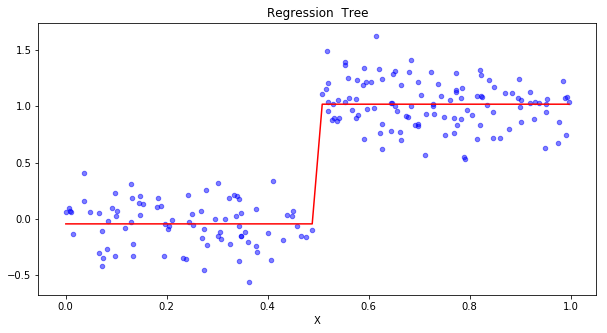

\sum of leaf nodes: 2.0 and tree depth: 1.0 and plotTree.xOff: -0.25 and plotTree.yOff: 1.0

factorX: 1 and factorY: 1


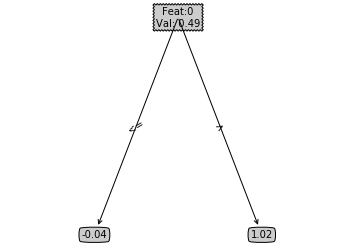

In [138]:
##   Regression tree: Data 1
dataList = loadDataSet_2("./input/data1.txt")
dataMat = np.mat(dataList)
tree_trained = createTree(dataMat)
yArr_pred = createForeCast(tree_trained, dataMat[:,0])
showTree(dataList, yArr_pred)
createPlot(tree_trained,1,1)

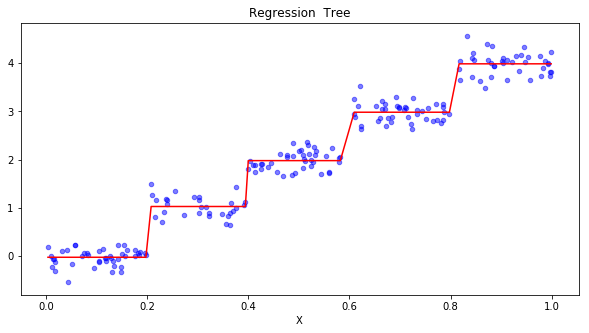

\sum of leaf nodes: 5.0 and tree depth: 3.0 and plotTree.xOff: -0.1 and plotTree.yOff: 1.0

factorX: 1 and factorY: 2


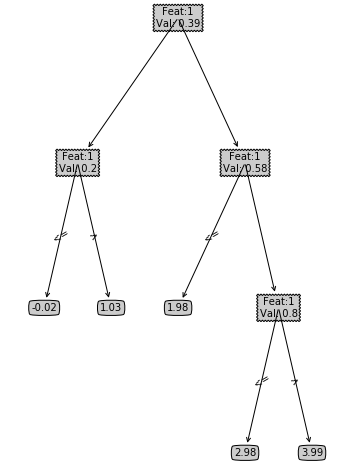

In [143]:
##   Regression tree: Data 2
dataList = loadDataSet_2("./input/data2.txt")
dataMat = np.mat(dataList)
tree_trained = createTree(dataMat)
yArr_pred = createForeCast(tree_trained, dataMat[:,:-1])
showTree(dataList, yArr_pred)
createPlot(tree_trained,1,2)

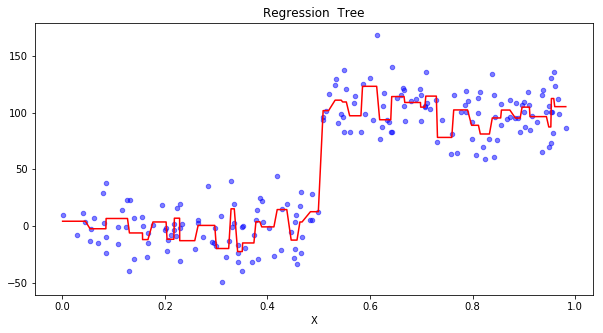

\sum of leaf nodes: 10.5 and tree depth: 12.0 and plotTree.xOff: -0.047619047619047616 and plotTree.yOff: 1.0

factorX: 2 and factorY: 3


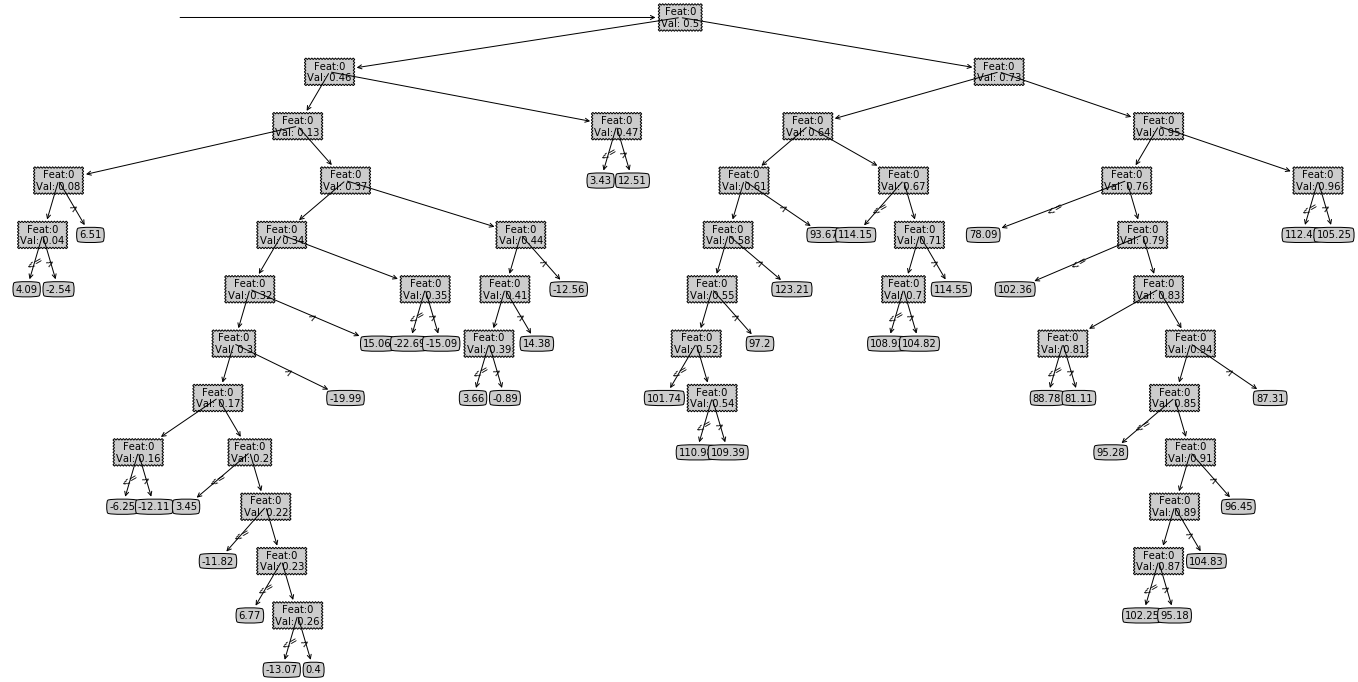

In [145]:
##   Regression tree: Data 3 (TRAIN, stopcondition(1,4))
dataList = loadDataSet_2("./input/data3.txt")
dataMat = np.mat(dataList)
tree_trained = createTree(dataMat, stopCond=(1,4))
yArr_pred = createForeCast(tree_trained, dataMat[:,0])
showTree(dataList, yArr_pred)
createPlot(tree_trained,2,3)

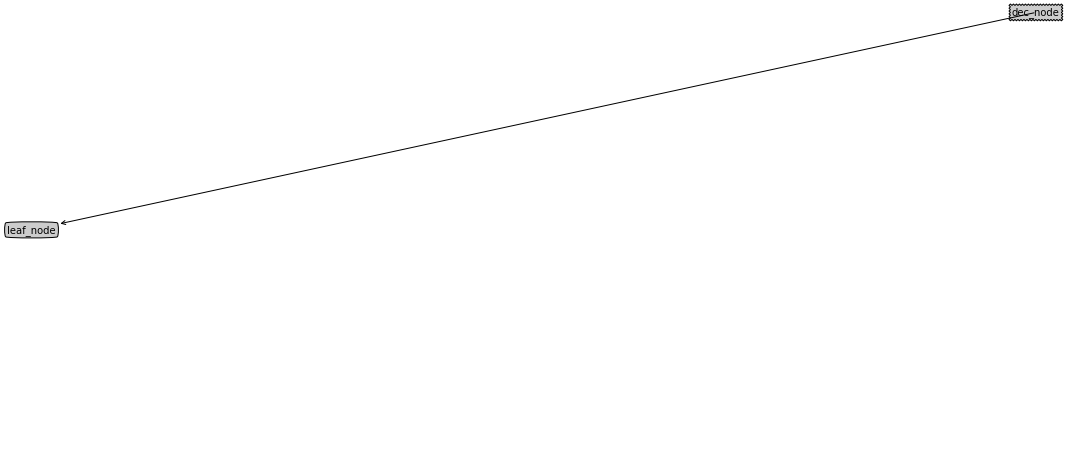

In [136]:
##  TEST plotNode
fig = plt.figure(1, facecolor='white')                                                  # create fig
fig.clf()                                                                               # clear fig
axprops = dict(xticks=[], yticks=[])
createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)                             # delete x、y轴
decisionNode = dict(boxstyle="sawtooth", fc="0.8")      # define decision node format，frame and arrow
leafNode = dict(boxstyle="round4", fc="0.8")            # define leaf node format

# plotNode(nodeTxt, centerPt, parentPt, nodeType). rule: parent point to center!           
plotNode("dec_node", (2.0, 2.0), (2.0, 2.0), decisionNode)      # plot left node   
plotNode("leaf_node", (-1.0, 1.0), (2.0, 2.0), leafNode)      # plot left node